# Analyzing Data Between NYC High Schools and SAT Results

The Scholastic Apitude Test, or SAT, is a standardized test for college entrance that millions of high-school students take each year. Because the SAT is one of the criteria colleges and universities use in deciding which students to admit, it is important that students do fairly well on the exam to procure admissions to their institutions of choice. In the data we will be exploring, the SAT is composed of three sections (Critical Reading, Writing, and Math) each graded out of 800 points to form a 2400 composite score. It has since been updated to give a total score of 1600.

However, the SAT has long been under scrutiny – there have been many critics voicing the low efficacy of these tests in predicting who can succeed in college level coursework. In addition, many critics have commented on how the tests are unfair to certain groups with less resources, dispelling the meritocracy claims standardized tests make.

In order to investigate, I will be analyzing the correlations between demographics (across race and gender specifically) and SAT scores. I will be focusing on New York City public high schools, because of their diversity and accessibility of data from the City of New York. 

The datasets we'll use include: data on [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e), [class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3), [demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j), [graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a), [directory of high schools](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2), and [SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4). All data is available from the City of New York and can be downloaded as CSV files.

There are some facts we will use when guiding our analysis:

- New York City is made up of five boroughs (Manhattan, Queens, Brooklyn, Staten Island, the Bronx)
- Only high school students take the SAT, so we'll focus on high schools in the area in our analysis
- New York City schools fall within multiple  school districts, each of which can contains dozens of schools
- Each school in New York City has a unique code given to them called a DBN, or district borough number
- Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences

In addition, we see that our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.

In order to move on we'll read each file into a pandas dataframe. We will then store all of the dataframes in a dictionary to reference them later on.

## Reading in the Data and Some Initial Findings

In [2]:
import pandas as pd
import re
import numpy as np

data_files = [
    "/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/ap_2010.csv",
    "/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/class_size.csv",
    "/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/demographics.csv",
    "/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/graduation.csv",
    "/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/hs_directory.csv",
    "/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/sat_results.csv"
]
data = {}
for file in data_files:
    df = pd.read_csv(file)
    key_name = file.replace(".csv","").replace("/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/","")
    data[key_name] = df

Because we are interested in the correlations between SAT scores and demographics, the `2012_SAT_Results.csv` is one of our more important datasets. We'll be further exploring this dataset to see what inferences we can make. Let's display the first five rows of this dataset.

In [3]:
data['ap_2010'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


We can observe a few things about this dataset from the output:

- Each school has a unique DBN, or identification number which we'll be able to use in analysis
- Because there is a single row for each high school, we know the DBN number is unique
- We may  want to combine the three columns that contain SAT scores – `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` -- into a single column to make the scores easier to analyze.

Next, we'll read in two surveys from the City of New York with surveys of parents, teachers, and students at each school with valuable information. The surveys can be downloaded [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8).

In [4]:
all_survey = pd.read_csv("/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/masterfile11_gened_final.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/masterfile11_d75_final.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Cleaning of the Data

Now, we'll add `DBN` columns to our `data` dataset. This will allow us to analyze data across datasets – for example, the `class_size` and `hs_directory` datasets do not have a `DBN` column. `hs_directory` has a `dbn` column which we can rename to `DBN`. `class_size`, however, does not have this column at all.

We can take a look at the first few rows of the `class_size` dataset and a few from the `sat_results` dataset, which does have a `DBN` column.

In [5]:
print(data['class_size'].head())
print(data['sat_results'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


We can see the `CBN` is a combination of the `CSD` and `SCHOOL CODE` columns in class_size. Below, we'll use this information to create a padded `DBN` column in `class_size`.

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

Our data would be easier to analyze if we could sum the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns of the `sat_results` dataset. We'll do that below, as well as change the values from string to float using the `to_numeric()` function. 

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

print(data['sat_results'].head())


      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  
0                404.0                   363.0     1122.0  
1                423.0                   366.0     1172.0  
2                402.0                   370.0     1149.0  
3                401.0          

Now, we can see a combined `sat_score` within the dataset.

Next, we'll focus on clarifying the locations of schools. We're provided locations – ex. Location 1, 2 – that include coordinates. We'll define two functions to return the latitude and longitude of schools and create a new column in the `hs_directory` dataset.

In [8]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

Because our analysis, as said before, is only dealing with high schools, we will exclude all high schools except those with grades 9-12. In the `class_size` dataset, we'll do this explicitly. We'll also set `PROGRAM TYPE` in the dataset to `GEN ED` because it is the most popular. After that, we'll aggregate the data by `DBN` to be able to compare across schools more efficiently.

In [9]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

Now, we'll focus on condensing the `demographics` dataset. We want each `DBN` to have a unique row and no duplicates. We'll only select rows where `schoolyear` is `20112012`.

In [10]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

Next, we'll condense the `graduation` dataset. We'll only accept values where `Cohort` equals `2006` (the most recent available) and `Demographic` is the `Total Cohort`. These two columns are what prevent `DBN` from being unique, so if we limit them, we'll be able to work with unique DBNs.

In [11]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

Lastly, we'll convert AP scores in the `ap_2010` dataset to floats – currenrly, they're stored as strings. To use numeric operations in analysis, we'll convert them below.

In [12]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

Before moving on, we'll delete the `DBN` from `survey_fields` as its a unique identifier and won't be useful for further numeric analysis. We'll also remove the trailing space from the `AP Test Takers ` column.

In [13]:
survey_fields.remove("DBN")
data['ap_2010']['AP Test Takers'] = data['ap_2010']['AP Test Takers ']

## Combining the Datasets

Now that we have finished preliminary cleaning, we can combine our datasets in order to start analysis. 

Because it is a unique identifier among schools, we'll be using the `DBN` column across datasets to identify matching rows. This way, we'll know how to combine the data.

Because there are inconsistencies in the data due to human error or other errors, as well as `DBN` values that could exist in one dataset but not the other, some data will be lost while merging. Because our analysis is mostly centered around SAT scores, we'll be merging primarily with the `sat_results` dataset in mind.

Our combined dataframe will be called `combined`.

In [14]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

`combined` has null values in some spaces. As a result, we'll first try to fill these values with the mean of the column. Any remaining missing values will be filled with a 0. In `combined`, we'll also add a column called `school_dist` – school district – so we can map using Basemap better later on. The school district code can be found with the first two characters of the `DBN`.

In [15]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Quick Analysis Using Correlations

To start some of our analysis, we'll create a dataframe called `correlations` that will find the pairwise correlation of all columns in the dataframe. We'll then narrow that dataframe to only the `sat_score` column because SAT scores are what is guiding our analysis question.

In [16]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 86, dtype: float64


Above we see that `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` are unsurprisingly correlated with total SAT score. We see that AP Test Takers are the next best indicator of high SAT scores.

## Plotting Survey Fields Against SAT Scores

Now, we'll use matplotlib to create a bar plot of the correlations between `survey_fields` and `sat_scores`. As a reminder, `survey_fields` originally came from a survey in 2011 of parents, teachers, and students about markers of the quality of education, including enrollment size, number of eligible teachers, safe and respect score, and more. The full data dictionary can be found [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) for reference.

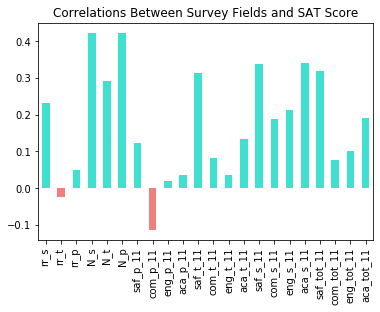

In [17]:
import matplotlib.pyplot as plt
colors = ['turquoise' if (x > 0) else 'lightcoral' for x in combined.corr()['sat_score'][survey_fields]]
combined.corr()['sat_score'][survey_fields].plot.bar(color=colors, title="Correlations Between Survey Fields and SAT Score")

We see that the factors most highly correlated with SAT score include the number of student respondents (`N_s`), the number of parent respondents (`N_p`), the safety and respect score based on teacher responses (`saf_t_11`), the safety and respect score based on student responses (`saf_s_11`), the academic expectations score based on student responses (`aca_s_11`), and the safety and respect total score (`saf_tot_11`). 

These are expected results. If the number of student respondents and number of parent respondents are high, it implies a high level of engagement from both students and their supportive families. In addition, high safety and respect scores indicate a healthy environment for students, which is beneficial to them in their learning. Lastly, if the academic expecations score based on student responses is high, it infers the students' strong engagement with their education.

There are factors correlated with lower SAT scores: the teacher response rate (`rr_t`) and the communication score based on parent responses (`com_p_11`). There are no obvious explanations for these two factors, but hopefully our analysis will clear things up.

Because the safety and respect score based on teacher responses (`saf_t_11`) and the safety and respect score based on student responses (`saf_s_11`) were correlated highly with SAT scores, we'll investigate them further. We'll create a scatter plot of `saf_s_11` and our column `sat_score` in `combined`.

Text(0, 0.5, 'SAT Scores')

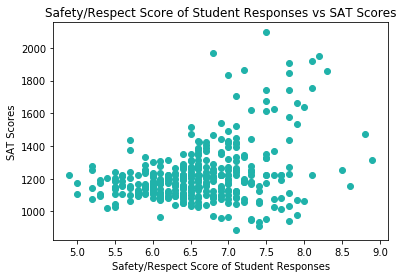

In [18]:
plt.scatter(combined['saf_s_11'], combined['sat_score'], color='lightseagreen')
plt.title("Safety/Respect Score of Student Responses vs SAT Scores")
plt.xlabel('Safety/Respect Score of Student Responses')
plt.ylabel('SAT Scores')

We now see a strong visual relationship between the safety/respect score of student responses and SAT scores. As we said before, this makes sense given a high safety/respect score infers a healthy learning environment for students to thrive.

## Mapping the Average Safety Score by District

Now, we'll compute the average safety score for each district and present our findings visually.

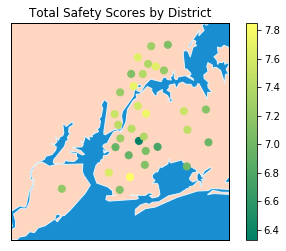

In [19]:
school_district = combined.groupby("school_dist").agg(np.mean)

from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

latitudes = school_district['lat'].tolist()
longitudes = school_district['lon'].tolist()

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#198ed1')
m.drawcoastlines(color='#e3f5ff', linewidth=1)
m.fillcontinents(color='#ffd6bf',lake_color='aqua')

m.scatter(longitudes, latitudes, zorder=4, s=50, latlon=True, c=school_district['saf_tot_11'], cmap='summer')

plt.title("Total Safety Scores by District")
plt.colorbar()
plt.show()

From our map projection above, we can see that the schools with the highest safety scores tend towards the Manhattan borough while the schools with the lowest safety scores tend to cluster in the northern Brooklyn, Queens, Bronx areas. This may affect SAT performance among these areas, as safety score is correlated to SAT scores.

## Investigating Racial Differences Across SAT Scores

In our `combined` dataset, there are a few columns that provide us the percentage of each race at a given school. These columns are listed below:

- `black_per`
- `white_per`
- `asian_per`
- `hispanic_per`

In order to determine if there are aggregate racial difference in SAT performance, we'll plot out the correlations between these columns and SAT score. If we find significant differences, this could support claims of standardized testing being unfair to certain racial groups/advantaging others due to systemic differences.

Text(0, 0.5, 'Correlation')

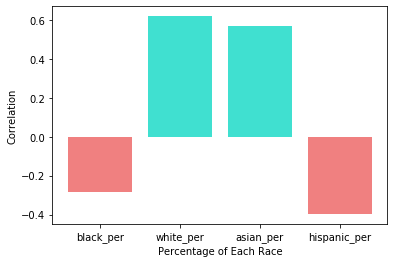

In [20]:
cols = ['black_per', 'white_per', 'asian_per', 'hispanic_per']
colors = ['turquoise' if (x > 0) else 'lightcoral' for x in combined.corr()['sat_score'][cols]]
plt.bar(cols, combined.corr()['sat_score'][cols], color=colors)
plt.xlabel("Percentage of Each Race")
plt.ylabel("Correlation")

We can clearly see above that the `white_per` and `asian_per` are highly correlated with SAT scores while the `black_per` and `hispanic_per` and negatively correlated with SAT scores.

In order to investigate this further, we'll explore schools with low SAT scores and high percentages for `hispanic_per`.

Text(0, 0.5, 'SAT Score')

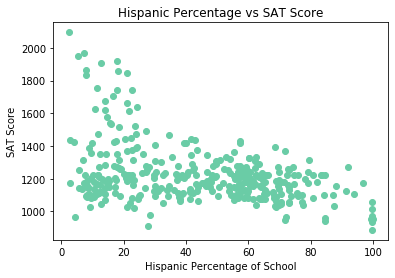

In [21]:
plt.scatter(combined['hispanic_per'], combined['sat_score'], color="#6acca6")
plt.title("Hispanic Percentage vs SAT Score")
plt.xlabel("Hispanic Percentage of School")
plt.ylabel("SAT Score")

We see that as the Hispanic percentage of the school goes up, the average SAT score of the school decreases. Next, we'll research schools with a `hispanic_per` greater than 95%.

In [22]:
his_95 = combined[combined['hispanic_per'] > 95]
his_95.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135.000000,1.083802e+06,1.010790e+09,Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269.000000,1.063703e+06,1.021550e+09,Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,3760.027701,2.587480e+06,2.515083e+09,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,21502.000000,2.008460e+06,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409.000000,2.015241e+06,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10


A Google search of some of these schools offers some explanatory information. For example, the first school, Manhattan Bridges High School is a school "that caters to immigrants recently arrived from Spanish-speaking countries". Similarly, the International School for Liberal Arts is "designed to offer Spanish-speaking teens a gentle transition to English". Because SAT exams require a strong command of English that is difficult for even native speakers, this information explains some of the negative correlation. One may recommend that the SAT be modified to be fairer to students whose first language is not English.

Now, we'll look at schools with a `hispanic_per` less than 10% and an average SAT score greater than 1800.

In [23]:
his_10_1800 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
his_10_1800.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409.0,2094706.0,2.032510e+09,Van Cortlandt Village ...,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33.0,3058752.0,3.020980e+09,Fort Greene ...,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246.0,4215611.0,4.100990e+09,Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31


The first high school we see is Stuyvesant High School, an internationally known publicly funded high school in Manhattan that has produced many world-class leaders and technologists. Stuyvesant requires an entrance examination to be admitted, and this exam has been criticized for disadvantaging African-Americans and Hispanics because they are less likely to be able to access resources to perform to Stuyvesant's requirement. 

Like Stuyvesant, the Bronx High School of Science also has graduated many world-class alumni, including 8 Nobel Laureates. However it also requires the Specialized High Schools Admissions Test, and has been similarly criticized for disadvantaging African-American and Hispanic communities. 

There are efforts to implement versions of affirmative action in these schools.

## Investigating Gender Differences Across SAT Scores

Now, we'll move onto investigating gender differences in SAT scores.

Text(0.5, 1.0, 'Correlation Between Gender Percentages and SAT Score')

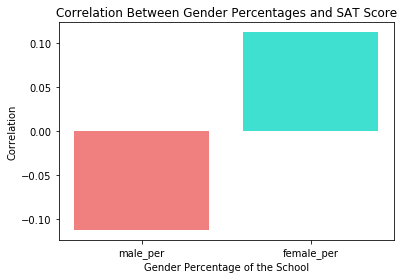

In [24]:
gender_cols = ['male_per', 'female_per']
colors = ['turquoise' if (x > 0) else 'lightcoral' for x in combined.corr()['sat_score'][gender_cols]]
plt.bar(gender_cols, combined.corr()['sat_score'][gender_cols], color=colors)
plt.xlabel('Gender Percentage of the School')
plt.ylabel('Correlation')
plt.title('Correlation Between Gender Percentages and SAT Score')

We see a clear positive correlation between the female percentage of the school and SAT score and a clear negative correlation between the male percentage of the school and SAT score.

In order to investigate this further, we'll look at schools with high SAT scores and a high `female_per`.

Text(0.5, 1.0, 'Female Percentage of Schools vs Average SAT')

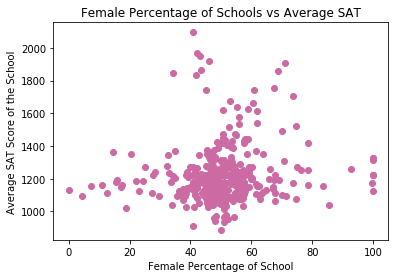

In [25]:
plt.scatter(combined['female_per'], combined['sat_score'], color="#cc6aa3")
plt.xlabel("Female Percentage of School")
plt.ylabel("Average SAT Score of the School")
plt.title("Female Percentage of Schools vs Average SAT")

This scatterplot seems to suggest that some of the highest SAT score schools come from schools with a 50/50 percentage between males and females.

We'll now look at schools with a `female_per` greater than 60% and an average SAT score greater than 1700.

In [26]:
high_fem_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
high_fem_sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,"525 East Houston Street\nNew York, NY 10002\n(...",3.0,2.0,1002.0,1004062.0,1.003250e+09,Lower East Side ...,40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,"411 East 76 Street\nNew York, NY 10021\n(40.77...",8.0,5.0,132.0,1045949.0,1.014710e+09,Lenox Hill-Roosevelt Island ...,40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,"227 243 West 61St Street\nNew York, NY 10023\n...",7.0,6.0,151.0,1030328.0,1.011540e+09,Lincoln Square ...,40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",7.0,6.0,151.0,1030341.0,1.011560e+09,Lincoln Square ...,40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,"149 11 Melbourne Avenue\nFlushing, NY 11367\n(...",8.0,24.0,809.0,4538714.0,4.065070e+09,Kew Gardens Hills ...,40.734408,-73.821417,25


All the above schools are high-performing and selective high schools, LaGuardia High School is primarily a music and arts institution while Townsend Harris High School is a public magnet high school.

## Exploring AP Test Takers and SAT Scores

In the U.S., Advanced Placement (AP) classes are offered at many high schools to provide an introduction to college-level coursework and to earn college credit. Because of the rigor of these courses, it makes sense that a school with a high level of AP test takers would have a high average SAT score. We'll now explore this relationship.

We see that `total_enrollment` is highly correlated with `sat_score` (more students taking the exam), so we'll instead look at the percentage of students in each school who took at least one exam.

Text(0.5, 1.0, 'Percentage of AP Students vs Average SAT Score')

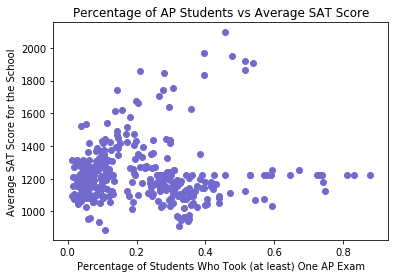

In [27]:
combined['ap_per'] = combined['AP Test Takers'] / combined['total_enrollment']

plt.scatter(combined['ap_per'], combined['sat_score'], color="#726acc")
plt.xlabel("Percentage of Students Who Took (at least) One AP Exam")
plt.ylabel("Average SAT Score for the School")
plt.title("Percentage of AP Students vs Average SAT Score")

From this scatterplot, we see that the percentage of students who took AP exams is slightly positively correlated with SAT score. The plot doesn't seem to infer an especially strong relationship as might be expected.

## Analyzing the Cheapest Boroughs and School Performance

We'll investigate which cheaper boroughs have the best schools. We will use another dataset – `nyc-rolling-sales` from the City of New York that is a record of every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period (September 2016 - 2017). From this dataset, we'll try to see what are the best schools in the least expensive neighborhoods.

In [28]:
nyc_sales = pd.read_csv("/Users/natasharavinand/Downloads/datasets/Projects/NYC:SAT/nyc-rolling-sales.csv")
nyc_sales.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


We are specifically interested in the `BOROUGH` and `SALE PRICE` columns. The data dictionary tells us that the number codes for each borough are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5). In order to be compatible with our `combined` dataframe, we'll convert these numbers to their borough name.

In [29]:
def num_to_borough(num):
    if num == 1:
        return "Manhattan"
    elif num == 2:
        return "Bronx"
    elif num == 3:
        return "Brooklyn"
    elif num == 4:
        return "Queens"
    elif num == 5:
        return "Staten Island"

nyc_sales['BOROUGH'] = nyc_sales['BOROUGH'].apply(num_to_borough)
nyc_sales['BOROUGH']

0            Manhattan
1            Manhattan
2            Manhattan
3            Manhattan
4            Manhattan
             ...      
84543    Staten Island
84544    Staten Island
84545    Staten Island
84546    Staten Island
84547    Staten Island
Name: BOROUGH, Length: 84548, dtype: object

Next, we'll convert the values in the `SALE PRICE` column from string to numeric.

In [30]:
nyc_sales['SALE PRICE'] = pd.to_numeric(nyc_sales['SALE PRICE'], errors='coerce')

Now, we'll aggregate the average sales price per neighborhood.

In [31]:
sp_borough = nyc_sales.groupby('BOROUGH').agg(np.mean)['SALE PRICE']
sp_borough.sort_values(ascending=False)

BOROUGH
Manhattan        3.337951e+06
Brooklyn         8.344884e+05
Queens           7.399086e+05
Bronx            5.901936e+05
Staten Island    5.434721e+05
Name: SALE PRICE, dtype: float64

We see that Manhattan is the most expensive borough, followed by Brooklyn, Queens, Bronx, and Staten Island. This is relevant when considering our previous analysis of schools with the lowest safety scores – schools with the highest safety scores (and subsequent correlation with high average SAT scores) were mainly concentrated in Manhattan, which also appears to be the richest borough. Such inference points to systemic disadvantage among poorer communities.

In order to move further in our analysis, we'll now attempt to filter for schools that are in Staten Island with an average SAT score of at least 1800 and `ap_per` of at least 40%.

In [32]:
si_good_schools = combined[(combined['borough'] == 'Staten Island') & (combined['sat_score'] > 1800) \
& combined['ap_per'] > 0.4]
si_good_schools.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist,ap_per
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31,0.478261


In terms of a good school in a cheaper borough of the City, the Staten Island Technical High School seems to be a good choice. Its average SAT score 1953. Let's compare this to other schools in Staten Island.

In [33]:
combined[combined['borough'] == 'Staten Island'].agg(np.mean)['sat_score']

1382.5

We see that other schools in Staten Island have an average SAT score of 1382.5, which is a very large difference of 570.5 points.

# Using Machine Learning to Predict Boroughs From Academic and Demographic Indicators

Next, we will use machine learning to predict boroughs from academic and demographic indicators.

## Random Forests

Now, we will use Random Forests, which is a combination of decision tree classifiers. Random forests use a bagging approach to create a variety of decision trees with random parts of the total data; therefore, the model achieves better prediction accuracy, and all decisions trees are used to reach a final decision.

We can implement a random forest below:

In [462]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 10)
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
accuracy_score(y_test, predicted, normalize=True)

0.684931506849315

We see our accuracy score is about 70%, which is better than above.

Text(0.5, 1.0, 'Model Performance for Random Forests')

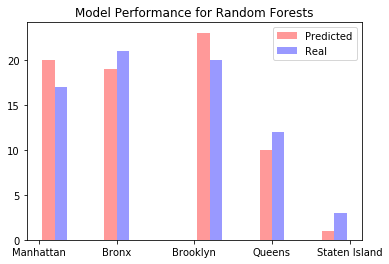

In [463]:
f, ax = plt.subplots(1,1)
plt.hist([predicted, y_test], color=['r', 'b'], alpha = 0.4)
ax.legend(['Predicted', 'Real'])
plt.title("Model Performance for Random Forests")

Here, we see the model performs much better accross all boroughs besides Staten Island – this may be due to a lack of data on Staten Island.

In order to obtain a better accuracy score, it we may have to further preprocess the data and conduct feature selection in another project.

## Conclusion

The path to college entrance in America has many problems, one of which being standardized testing (ex. the SAT) that disadvantages certain communities.

We found there to be high positive correlations between safety scores and student/parent engagement, both indicators of healthy environments which can contribute to higher SAT scores. This makes sense, as this would provide a space that is conducive to learning.

We also found negative correlations between percentages of African-American and Hispanic students in SAT scores. However, I argue this is clearly a result of systemic disadvantage of those in wealthier communities having access to resources to help them perform better – for example, we found very low percentages of African-American and Hispanic students at top-rated public high schools (ex. Stuyvesant High School) that require admissions tests. These schools tend to have higher SAT scores and send more students to competitive colleges. In addition, we saw that high schools with high Hispanic percentages and low SAT scores tended to be high schools where many students do not speak English as a native language. Thus, when taking exams such as the SAT (which are difficult for even native English speakers), they are understandably disadvantaged by no fault of their own.

There must be systemic change in the standardized test and college admissions process. We must break the cycle of those in disadvantaged communities not gaining access to top college educations that can allow for greater opportunities in the future on a structural level.